Utilizes the ResNet50 model for transfer learning, exploring:
- Fine-tuning the model to improve classification accuracy (with class weighting)
- Prediction accuracy and complexity metrics as a function of model pruning

In [1]:
# "standard"
import numpy as np

# machine learning and statistics
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras import applications, models, layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight

# plotting
import matplotlib.pyplot as plt

# misc
from IPython.display import clear_output

# src
import sys, os, pickle
from pathlib import Path
script_dir = Path(os.getcwd()).parent
src_dir = script_dir / 'src'
sys.path.append(str(src_dir))
from visualize import visualize_training, multiclass_summary
from custom_pruning import global_prune_model

clear_output(wait=False)

Create results directory

In [2]:
script_dir = Path(os.getcwd()).parent
results_dir_00 = script_dir / 'results' / 'notebook_00'

results_dir_03 = script_dir / 'results' / 'notebook_03'
os.makedirs(results_dir_03, exist_ok=True)

In [3]:
# Load data file and unpack contents
file_name = results_dir_00 / 'data_preprocessed.pkl'
with open(file_name, 'rb') as f:
    data_preproc = pickle.load(f)

train_data=data_preproc['train_data']
train_lab=data_preproc['train_labels']
test_data=data_preproc['test_data']
test_lab=data_preproc['test_labels']
class_lab = ['Mild', 'Moderate', 'None', 'Very Mild']
    
# Convert labels to categorical
train_lab_cat = to_categorical(train_lab.astype('int8'), num_classes=4)
test_lab_cat = to_categorical(test_lab.astype('int8'), num_classes=4)

Load and adapt ResNet50

In [4]:
# load ResNet50
res_model = applications.ResNet50(
    include_top=False,
    weights=None,
    input_shape=(train_data.shape[1], train_data.shape[2], 3)
)
clear_output(wait=False)

# Freeze all layers except the last block
for layer in res_model.layers[:-10]:
    layer.trainable = False

# Print layers to verify
for i, layer in enumerate(res_model.layers[140:], start=140):
    print(f"Layer {i}: {layer.name}, Trainable: {layer.trainable}")

# Add a Conv2D layer to convert grayscale images to 3 channels
input_layer = layers.Input(shape=(128, 128, 1))
x = layers.Conv2D(3, (3, 3), padding='same')(input_layer)
x = res_model(x)
x = layers.Flatten()(x)
x = layers.Dense(len(np.unique(train_lab)), activation='softmax')(x)  # Add Dense layer with number of unique classes

Layer 140: conv4_block6_3_bn, Trainable: False
Layer 141: conv4_block6_add, Trainable: False
Layer 142: conv4_block6_out, Trainable: False
Layer 143: conv5_block1_1_conv, Trainable: False
Layer 144: conv5_block1_1_bn, Trainable: False
Layer 145: conv5_block1_1_relu, Trainable: False
Layer 146: conv5_block1_2_conv, Trainable: False
Layer 147: conv5_block1_2_bn, Trainable: False
Layer 148: conv5_block1_2_relu, Trainable: False
Layer 149: conv5_block1_0_conv, Trainable: False
Layer 150: conv5_block1_3_conv, Trainable: False
Layer 151: conv5_block1_0_bn, Trainable: False
Layer 152: conv5_block1_3_bn, Trainable: False
Layer 153: conv5_block1_add, Trainable: False
Layer 154: conv5_block1_out, Trainable: False
Layer 155: conv5_block2_1_conv, Trainable: False
Layer 156: conv5_block2_1_bn, Trainable: False
Layer 157: conv5_block2_1_relu, Trainable: False
Layer 158: conv5_block2_2_conv, Trainable: False
Layer 159: conv5_block2_2_bn, Trainable: False
Layer 160: conv5_block2_2_relu, Trainable: Fal

In [5]:
# Combine new input layer to ResNet50
model = models.Model(inputs=input_layer, outputs=x)
std_learning_rate = 1e-4
model.compile(optimizer = keras.optimizers.Adam(learning_rate = std_learning_rate),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │       131,076 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,718,818 (90.48 MB)

 Trainable params: 4,596,770 (17.54 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

In [6]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_lab),
    y=train_lab
)
class_weights_dict = dict(zip(np.unique(train_lab), class_weights))

In [7]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_data,
    train_lab_cat,
    epochs=50, 
    validation_data=(test_data, test_lab_cat),
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

clear_output(wait=False)

In [8]:
# Save model and history files
model.save(results_dir_03 / 'model_resnet50.h5')
print(f"Model saved to {results_dir_03 / 'model_resnet50.h5'}")

file_name = results_dir_03 / 'history_resnet50.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(history, f)

print(f"Data saved to {file_name}")

Model saved to c:\Users\Bjede\Documents\GitHub\Alzheimers-MRI-Classification\results\notebook_03\model_resnet50.h5
Data saved to c:\Users\Bjede\Documents\GitHub\Alzheimers-MRI-Classification\results\notebook_03\history_resnet50.pkl


View results

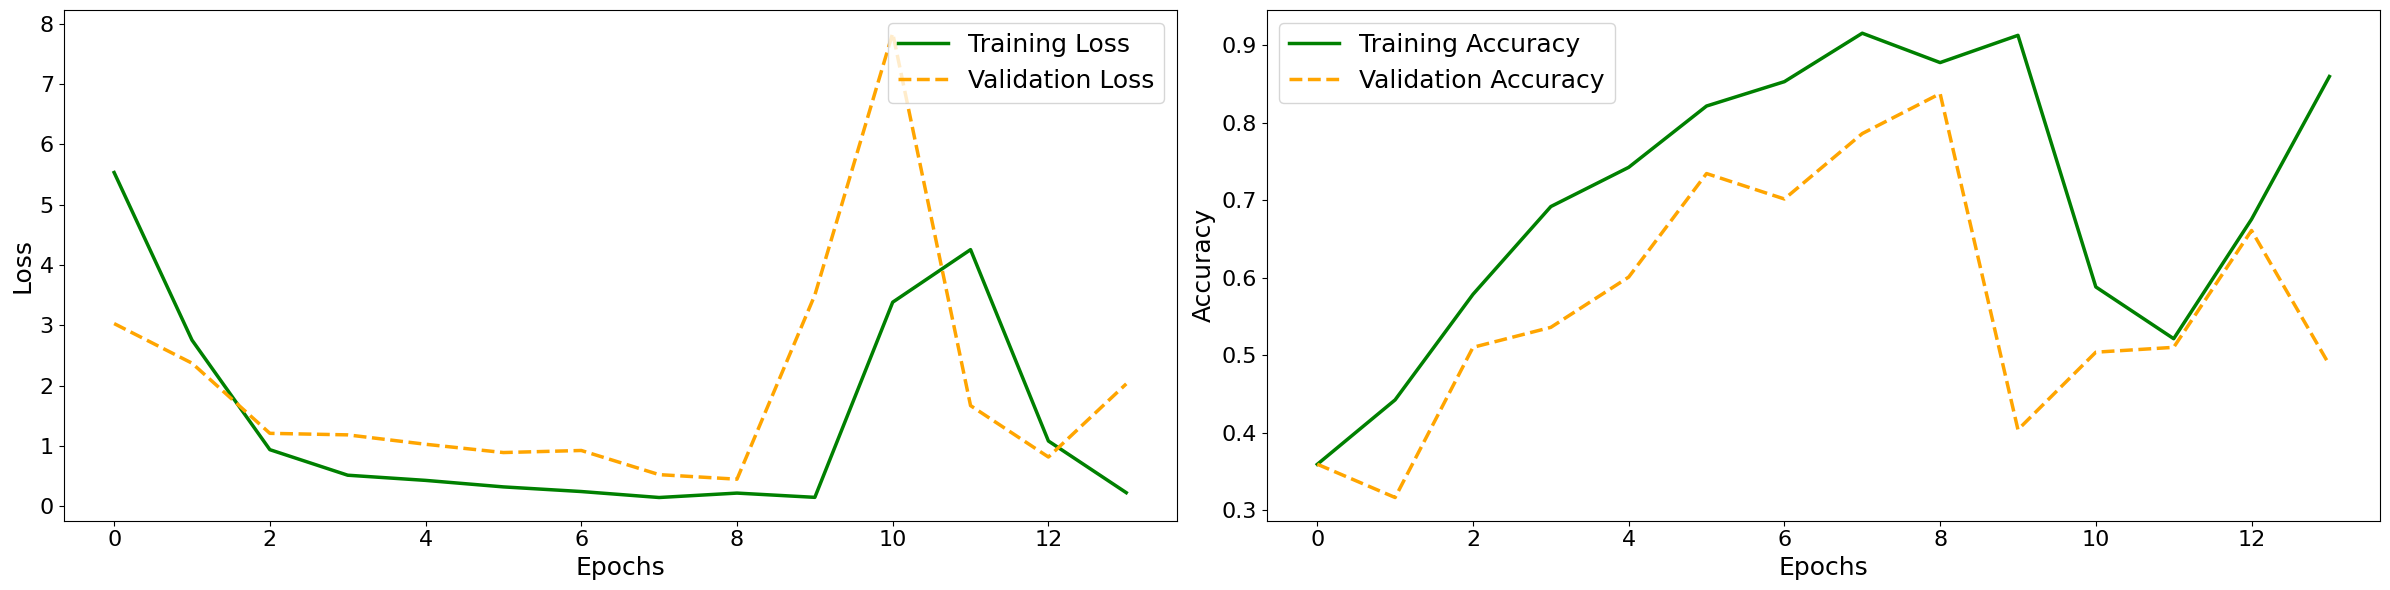

In [9]:
file_name = results_dir_03 / 'history_resnet50.pkl'
with open(file_name, 'rb') as f:
    history = pickle.load(f)
clear_output(wait=False)

visualize_training(history)

We can see that model training stopped after only 13 epochs due to our early stopping criteria - Validation loss began increasing after the eighth epoch and never truly recovered. Ideally, fine tuning this model by unfreezing layers/parameters can obtain a better fit. Since this AD dataset is small and still somewhat related to the Imagenet dataset (?), lets just unfreeze the last convolutional block.

Fine tune the ResNet50

In [10]:
# Load model
res_model = load_model(results_dir_03 / 'model_resnet50.h5')

# Unfreeze last whole convolutional block for fine tuning
# (rather than all, since this is a small dataset)
fine_tune_at = 143
for layer in res_model.get_layer('resnet50').layers[fine_tune_at:]: # only unfreeze layers in ResNet50 backbone
  layer.trainable = True

# Print layers to verify in resnet50 backbone
for i, layer in enumerate(res_model.get_layer('resnet50').layers[140:], start=140):
    print(f"Layer {i}: {layer.name}, Trainable: {layer.trainable}")

std_learning_rate = 1e-5 # use lower learning rate with more trainable layers
res_model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = std_learning_rate),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

res_model.summary()
        

Layer 140: conv4_block6_3_bn, Trainable: False
Layer 141: conv4_block6_add, Trainable: False
Layer 142: conv4_block6_out, Trainable: False
Layer 143: conv5_block1_1_conv, Trainable: True
Layer 144: conv5_block1_1_bn, Trainable: True
Layer 145: conv5_block1_1_relu, Trainable: True
Layer 146: conv5_block1_2_conv, Trainable: True
Layer 147: conv5_block1_2_bn, Trainable: True
Layer 148: conv5_block1_2_relu, Trainable: True
Layer 149: conv5_block1_0_conv, Trainable: True
Layer 150: conv5_block1_3_conv, Trainable: True
Layer 151: conv5_block1_0_bn, Trainable: True
Layer 152: conv5_block1_3_bn, Trainable: True
Layer 153: conv5_block1_add, Trainable: True
Layer 154: conv5_block1_out, Trainable: True
Layer 155: conv5_block2_1_conv, Trainable: True
Layer 156: conv5_block2_1_bn, Trainable: True
Layer 157: conv5_block2_1_relu, Trainable: True
Layer 158: conv5_block2_2_conv, Trainable: True
Layer 159: conv5_block2_2_bn, Trainable: True
Layer 160: conv5_block2_2_relu, Trainable: True
Layer 161: conv

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │       131,076 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,718,818 (90.48 MB)

 Trainable params: 15,107,106 (57.63 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

Notice how the number of trainable parameters has increased from ~5M to ~15M by unfreezing the last convolutional block of the ResNet50 backbone.

In [11]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_fine_tune = res_model.fit(
    train_data,
    train_lab_cat,
    epochs=50, 
    validation_data=(test_data, test_lab_cat),
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

clear_output(wait=False)

In [12]:
# Save model and history files
res_model.save(results_dir_03 / 'model_resnet50_fine_tune.h5')
print(f"Model saved to {results_dir_03 / 'model_resnet50_fine_tune.h5'}")

file_name = results_dir_03 / 'history_resnet50_fine_tune.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(history_fine_tune, f)

print(f"Data saved to {file_name}")

Model saved to c:\Users\Bjede\Documents\GitHub\Alzheimers-MRI-Classification\results\notebook_03\model_resnet50_fine_tune.h5
Data saved to c:\Users\Bjede\Documents\GitHub\Alzheimers-MRI-Classification\results\notebook_03\history_resnet50_fine_tune.pkl


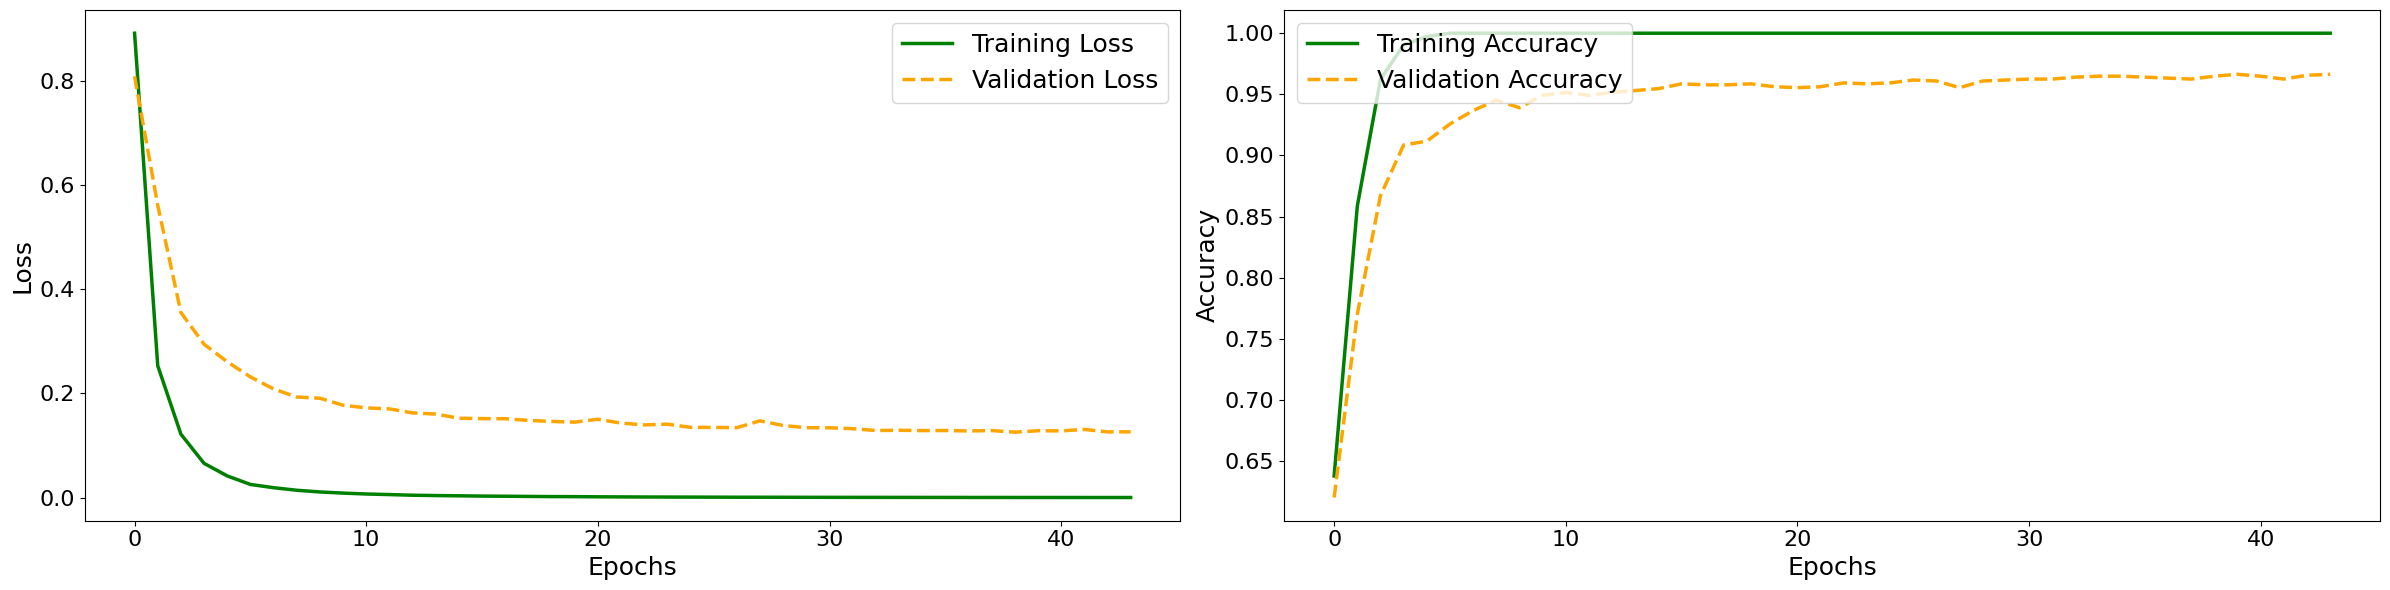

In [13]:
file_name = results_dir_03 / 'history_resnet50_fine_tune.pkl'
with open(file_name, 'rb') as f:
    history = pickle.load(f)
clear_output(wait=False)

visualize_training(history)

Clearly, we can see that when unfreezing additional layers in the ResNet50 model, performance increases dramatically. Performance is not only more stable that the default ResNet50 model and the custom CNN in the previous notebook, but also plateaus at a higher overall accuracy. Moreover, while gradual unfreezing is recommended for large-scale domain adaptation, this lighter fine-tuning already led to very strong results so I dont see the need to do that here.


Overall classification accuracy is: 96.48 %



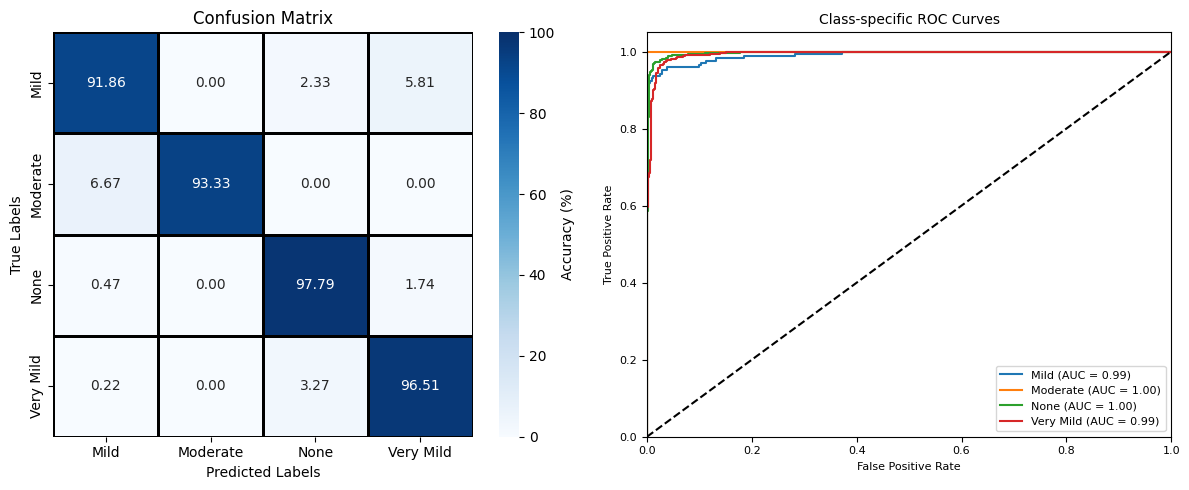

Mild - Precision: 0.97, Recall: 0.92, F1 Score: 0.94
Moderate - Precision: 1.00, Recall: 0.93, F1 Score: 0.97
None - Precision: 0.97, Recall: 0.98, F1 Score: 0.97
Very Mild - Precision: 0.95, Recall: 0.97, F1 Score: 0.96



In [14]:
# Load model
model = load_model(results_dir_03 / 'model_resnet50_fine_tune.h5')

# Predict test data
prob = model.predict(test_data)
clear_output(wait=False)
predict_classes = np.argmax(prob, axis=1)
result = predict_classes - test_lab
result_binary = np.argwhere(result == 0)
correct = np.size(result_binary, 0)
acc=correct/test_lab.shape[0] * 100

print()
print(f"Overall classification accuracy is: {acc:.2f} %")
print()

# Visualize summary of predictions
multiclass_summary(prob, test_lab, class_lab)
print()

When compared to the tuned CNN from the previous notebook, the fine-tuned ResNet50 exhibits a similar overall accuracy. Nevertheless, the class-specific accuracy and F1 score is greatly improved for the minory class (moderate AD). Furthermore, misclassified samples from this class are most commonly labeled as very mild AD, which is adjacent on the AD spectrum and make more physiological sense. Overall, these improvements appear minor at first, but still paint the most complete picture.

While not a pressing need, model pruning can be an important aspect of deep learning architectures, especially when considering deployment in ambulatory situations where portable devices and fast inference speeds will be meaningful factors regarding clinical acceptance.

In [15]:
# Load fine-tuned model
pre_pruned_model = load_model(results_dir_03 / 'model_resnet50_fine_tune.h5')

results = []
pruning_factors = np.arange(0, 1, 0.05)
for factor in pruning_factors:
    
    # Prune and re-compile model
    pruned_model = global_prune_model(pre_pruned_model, pruning_factor=factor)
    pruned_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

    test_loss, test_accuracy = pruned_model.evaluate(test_data, test_lab_cat, batch_size=32)

    # Calculate the number of parameters in the pruned model
    total_params = np.sum([np.count_nonzero(layer.get_weights()[0]) for layer in pruned_model.layers if len(layer.get_weights()) > 0])

    # Save results
    results.append({
        'pruning_factor': factor,
        'total_params': total_params,
        'test_accuracy': test_accuracy,
        'test_loss': test_loss
    })
    
clear_output(wait=False)

# Save history file
file_name = results_dir_03 / 'history_resnet50_fine_tune_pruning.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(results, f)

print(f"Data saved to {file_name}")

Data saved to c:\Users\Bjede\Documents\GitHub\Alzheimers-MRI-Classification\results\notebook_03\history_resnet50_fine_tune_pruning.pkl


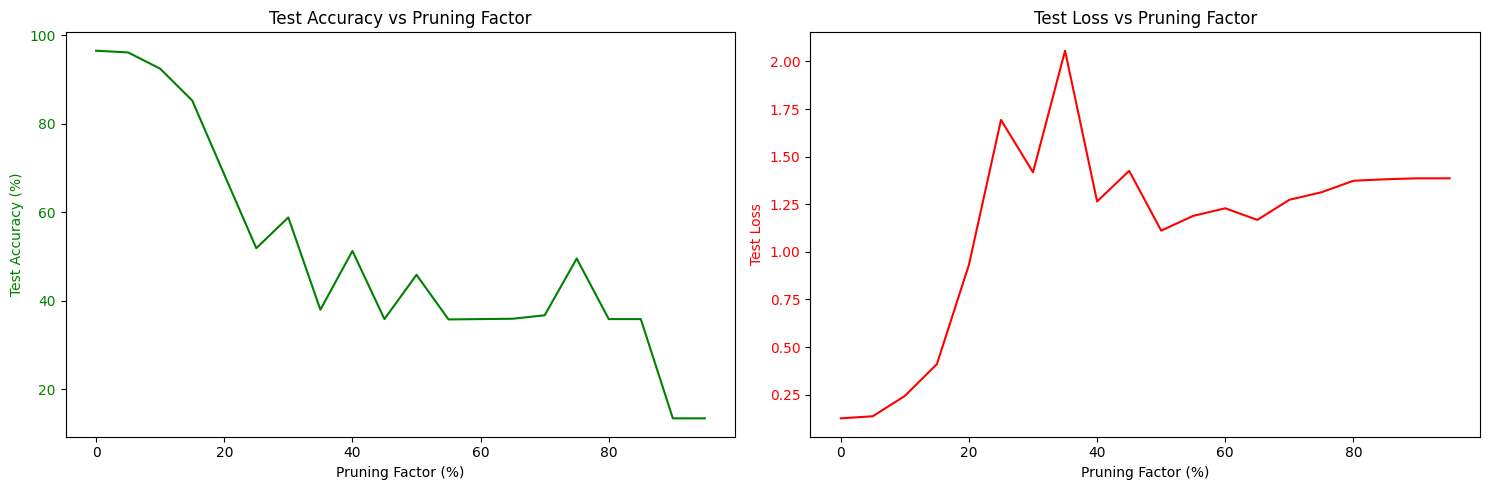

In [16]:
# Load history file
file_name = results_dir_03 / 'history_resnet50_fine_tune_pruning.pkl'
with open(file_name, 'rb') as f:
    results = pickle.load(f)
clear_output(wait=False)

pruning_factors = np.array([result['pruning_factor'] * 100 for result in results])
total_params = np.array([result['total_params'] for result in results])
test_accuracies = np.array([result['test_accuracy'] * 100 for result in results])
test_losses = np.array([result['test_loss'] for result in results])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot Test Accuracy
axes[0].plot(pruning_factors, test_accuracies, 'g-')
axes[0].set_xlabel('Pruning Factor (%)')
axes[0].set_ylabel('Test Accuracy (%)', color='g')
axes[0].tick_params(axis='y', labelcolor='g')
axes[0].set_title('Test Accuracy vs Pruning Factor')

# Plot Test Loss
axes[1].plot(pruning_factors, test_losses, 'r-')
axes[1].set_xlabel('Pruning Factor (%)')
axes[1].set_ylabel('Test Loss', color='r')
axes[1].tick_params(axis='y', labelcolor='r')
axes[1].set_title('Test Loss vs Pruning Factor')

plt.tight_layout()
plt.show()

While this is not a true pruning approach as the model is not re-structured after removing weights, this proof-of-concept pseudo-pruning gives us a sense of how many weights are likely to be important. With this, we can estimate that the model can be condensed ~15% without notably reducing performance. 